In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
class CNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, num_filters, kernel_sizes):
        super(CNNClassifier, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.conv_layers = nn.ModuleList([nn.Conv2d(1, num_filters, (k, self.embedding_dim)) for k in kernel_sizes])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        
    def forward(self,x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_results]
        cat = torch.cat(pooled, dim = 1)
        out = self.fc(cat).unsqueeze(0)
        return F.softmax(out, dim=-1)

In [3]:
class TClassifier(nn.Module):
    ''' Class of a VAE where both Encoder and Decoder are RNNs with GRU units

    Attributes
    ----------
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    hidden_dim : int, dimension of RNNs hidden state
    latent_dim : int, dimension of the VAE latent space
    style_dim : int, dimension of the style space within the latent space
    content_dim : int, dimension of the content space within the latent 
    vocab_size : int, number of unique tokens in the dataset
    sos_token : torch tensor of the 'start of the sequence' token
    num_layers : int, number of RNNs layers

    
    Methods
    -------
    forward(x) : perform the forward pass of the VAE
    reparametrization(mu, log_var) : perform the reparametrization trick
    reconstruction(x) : inference for reconstruction
    TST(x, new_style) : inference for Text Style Transfer
    '''

    def __init__(self, embedding_matrix, hidden_dim, num_layers):
        super(TClassifier, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(300, 10, batch_first = True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, 1)
        self.fc = nn.Linear(self.embedding_dim, 3)

    def forward(self, x):
        ''' Performs the VAE forward pass 
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
        

        Returns
        -------
        '''

        # embedding input and GRU encoder pass
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)
        out = self.encoder(embedded_input)
        
        out = out.mean(1).unsqueeze(1)
        out = out.permute(1,0,2)
        pred_label = self.fc(out)

        return pred_label

In [4]:
class GRUClassifier(nn.Module):
    ''' Class of a VAE where both Encoder and Decoder are RNNs with GRU units

    Attributes
    ----------
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    hidden_dim : int, dimension of RNNs hidden state
    latent_dim : int, dimension of the VAE latent space
    style_dim : int, dimension of the style space within the latent space
    content_dim : int, dimension of the content space within the latent 
    vocab_size : int, number of unique tokens in the dataset
    sos_token : torch tensor of the 'start of the sequence' token
    num_layers : int, number of RNNs layers

    
    Methods
    -------
    forward(x) : perform the forward pass of the VAE
    reparametrization(mu, log_var) : perform the reparametrization trick
    reconstruction(x) : inference for reconstruction
    TST(x, new_style) : inference for Text Style Transfer
    '''

    def __init__(self, embedding_matrix, hidden_dim, num_layers):
        super(GRUClassifier, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x):
        ''' Performs the VAE forward pass 
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
        

        Returns
        -------
        '''

        # embedding input and GRU encoder pass
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)
        _, hn = self.encoder(embedded_input)
        

        pred_label = self.fc(hn)

        return pred_label

In [5]:
class LSTMClassifier(nn.Module):
    ''' Class of a VAE where both Encoder and Decoder are RNNs with GRU units

    Attributes
    ----------
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    hidden_dim : int, dimension of RNNs hidden state
    latent_dim : int, dimension of the VAE latent space
    style_dim : int, dimension of the style space within the latent space
    content_dim : int, dimension of the content space within the latent 
    vocab_size : int, number of unique tokens in the dataset
    sos_token : torch tensor of the 'start of the sequence' token
    num_layers : int, number of RNNs layers

    
    Methods
    -------
    forward(x) : perform the forward pass of the VAE
    reparametrization(mu, log_var) : perform the reparametrization trick
    reconstruction(x) : inference for reconstruction
    TST(x, new_style) : inference for Text Style Transfer
    '''

    def __init__(self, embedding_matrix, hidden_dim, num_layers):
        super(LSTMClassifier, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x):
        ''' Performs the VAE forward pass 
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
        

        Returns
        -------
        '''

        # embedding input and GRU encoder pass
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)
        _, (hn, cn) = self.encoder(embedded_input)
        

        pred_label = self.fc(hn)

        return pred_label

In [6]:
class RNNClassifier(nn.Module):
    ''' Class of a VAE where both Encoder and Decoder are RNNs with GRU units

    Attributes
    ----------
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    hidden_dim : int, dimension of RNNs hidden state
    latent_dim : int, dimension of the VAE latent space
    style_dim : int, dimension of the style space within the latent space
    content_dim : int, dimension of the content space within the latent 
    vocab_size : int, number of unique tokens in the dataset
    sos_token : torch tensor of the 'start of the sequence' token
    num_layers : int, number of RNNs layers

    
    Methods
    -------
    forward(x) : perform the forward pass of the VAE
    reparametrization(mu, log_var) : perform the reparametrization trick
    reconstruction(x) : inference for reconstruction
    TST(x, new_style) : inference for Text Style Transfer
    '''

    def __init__(self, embedding_matrix, hidden_dim, num_layers):
        super(RNNClassifier, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x):
        ''' Performs the VAE forward pass 
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
        

        Returns
        -------
        '''

        # embedding input and GRU encoder pass
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)
        _, hn = self.encoder(embedded_input)
        

        pred_label = self.fc(hn)

        return pred_label

In [7]:
def loss_function(pred_labels, labels, loss_fn = nn.CrossEntropyLoss()):
    L = loss_fn(pred_labels.view(pred_labels.shape[1], pred_labels.shape[2]), labels.view(-1))

    return L

In [98]:
def training(model, train_loader, val_loader, num_epochs, lr = 4e-4, title = 'Training'):
    params = list(model.parameters())

    # three different optimizer
    optimizer = torch.optim.Adam(params, lr = lr)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0

        for  i, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            labels = labels.type(torch.LongTensor)

            optimizer.zero_grad()
            

            # forward pass through VAE
            pred_labels = model(data)
            
            # comuting total training loss
            loss_tot = loss_function(pred_labels.to(device),
                                     labels.to(device))
            
            loss_tot.backward()
            train_loss += loss_tot.item()


            optimizer.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss_tot.item() / len(data):.6f}')
        
        

        with torch.no_grad():
            for i, (data, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.to(device)

                labels = labels.type(torch.LongTensor)

                # forward pass through VAE
                pred_labels = model(data)
                
                
                # comuting total validation loss
                val_loss_tot = loss_function(pred_labels.to(device),
                                     labels.to(device))
                
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(data):.6f}')
            
            
        average_loss = train_loss / len(train_loader.dataset)
        train_losses.append(average_loss)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        # printing average training and validation losses
        print(f'====> Epoch: {epoch+1} Average train loss: {average_loss:.4f}, Average val loss: {average_val_loss:.4f}')
    
    # plotting training and validation curve at the end of the for loop 
    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

    return train_losses

In [9]:
def divide_text(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/2))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]

    return output_text

In [10]:
def custom_dataset(file1 : str, file2 : str, file3 : str, sequence_length, embedding_dim, batch_size, training_fraction):
    ''' Function creating dataset
    
    Inputs
    ----------
    file1 : str, name of the file containing the first corpus
    file2 : str, name of the file containing the second corpus
    sequence_length : int
    embedding_dim : int, number of dimension for the embedded words using Word2vec model
    batch_size : int
    training_fraction : float, fraction of training data
    
    
    Returns
    ----------
    dataloader_train : istance of torch.utils.data.Dataloader, training data
    dataloader_val : istance of torch.utils.data.Dataloader, validation data
    embedding_dim : int
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    word2vec : trained Word2vec model
    idx2word : dictionary from indices to words
    word2idx : dictionart from words to indices
    vocab_size : int, number of unique tokens
    style0_val : torch tensor containing every validation data belonging to first style
    style1_val : torch tensor containing every validation data belonging to second style'''

    # reading the two corpus
    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()

    with open(file3, 'r', encoding='utf-8') as f:
        text3 = f.read()
    

    # adding a special token for the start of the sequence
    text1 = '<sos> ' + text1 
    text = text1 + ' ' + text2 + ' ' + text3

    # divide the whole text to feed the Word2vec model
    divided_text = divide_text(text, sequence_length)

    # training the Word2vec model with the whole corpus
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = sequence_length, min_count=1, workers=4, epochs = 30)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    # creating the embedding matrix from the trained Word2vec model
    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


    # dividing only the first text
    text1_divided = divide_text(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])

    
    # dividing only the second text
    text2_divided = divide_text(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    text3_divided = divide_text(text3, sequence_length)
    data3 = torch.LongTensor([[word2idx[char] for char in text3_divided[i]] for i in range(len(text3_divided))])


    # defining training and validation data for the first style
    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]): int(training_fraction * data1.shape[0]) + int(0.1 * data1.shape[0])]
    data1_test = data1[int(training_fraction * data1.shape[0]) + int(0.1 * data1.shape[0]): ]

    # defining training and validation data for the second style
    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]): int(training_fraction * data2.shape[0]) + int(0.1 * data2.shape[0])]
    data2_test = data2[int(training_fraction * data2.shape[0]) + int(0.1 * data2.shape[0]): ]


    data3_train = data3[:int(training_fraction * data3.shape[0])]
    data3_val = data3[int(training_fraction * data3.shape[0]): int(training_fraction * data3.shape[0]) + int(0.1 * data3.shape[0])]
    data3_test = data3[int(training_fraction * data3.shape[0]) + int(0.1 * data3.shape[0]): ]

    # creating training and validation labels for the first style
    label0_train = torch.zeros(data1_train.shape[0])
    label0_val = torch.zeros(data1_val.shape[0])


    # creating training and validation labels for the second style
    label1_train = torch.ones(data2_train.shape[0])
    label1_val = torch.ones(data2_val.shape[0])


    label2_train = 2*torch.ones(data3_train.shape[0])
    label2_val = 2*torch.ones(data3_val.shape[0])


    # creating training and validation labels
    labels_train = torch.cat((label0_train, label1_train, label2_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val, label2_val), dim = 0)

    # creating training and validation data
    data_train = torch.cat((data1_train, data2_train, data3_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val, data3_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)

    dataset_train = TensorDataset(data_train, labels_train)

    # Create a training DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
   


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)

    dataset_val = TensorDataset(data_val, labels_val)

    # Create a validation DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    

    # validation data for both styles that will be used during inference
    style0_test = torch.LongTensor(data1_test)
    style1_test = torch.LongTensor(data2_test)
    style2_test = torch.LongTensor(data3_test)
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test

In [52]:
sequence_length = 20
batch_size = 32
embedding_dim = 300
hidden_dim = 8

In [53]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('divina_commedia.txt',
                                                                                                                                                        'uno_nessuno_e_i_malavoglia.txt',
                                                                                                                                                        'lo_cunto_de_li_cunti.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  633
len val loader:  80
total number of training samples:  20246
total number of validation samples:  2529
vocab size:  26606


In [12]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('inferno.txt',
                                                                                                                                                        'purgatorio.txt',
                                                                                                                                                        'paradiso.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  363
len val loader:  46
total number of training samples:  11606
total number of validation samples:  1450
vocab size:  12762


In [103]:
cnn_classifier = CNNClassifier(embedding_matrix, 3, 3, [3,3,3])

In [104]:
classifier_params = sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8139


 12%|█▎        | 1/8 [00:02<00:20,  2.92s/it]

====> Epoch: 1 Average train loss: 0.0194, Average val loss: 0.0181


 25%|██▌       | 2/8 [00:05<00:16,  2.83s/it]

====> Epoch: 2 Average train loss: 0.0178, Average val loss: 0.0179


 38%|███▊      | 3/8 [00:08<00:14,  2.81s/it]

====> Epoch: 3 Average train loss: 0.0176, Average val loss: 0.0179


 50%|█████     | 4/8 [00:11<00:11,  2.80s/it]

====> Epoch: 4 Average train loss: 0.0175, Average val loss: 0.0178


 62%|██████▎   | 5/8 [00:14<00:08,  2.80s/it]

====> Epoch: 5 Average train loss: 0.0174, Average val loss: 0.0178


 75%|███████▌  | 6/8 [00:16<00:05,  2.80s/it]

====> Epoch: 6 Average train loss: 0.0174, Average val loss: 0.0179


 88%|████████▊ | 7/8 [00:19<00:02,  2.81s/it]

====> Epoch: 7 Average train loss: 0.0174, Average val loss: 0.0178


100%|██████████| 8/8 [00:22<00:00,  2.81s/it]

====> Epoch: 8 Average train loss: 0.0173, Average val loss: 0.0178


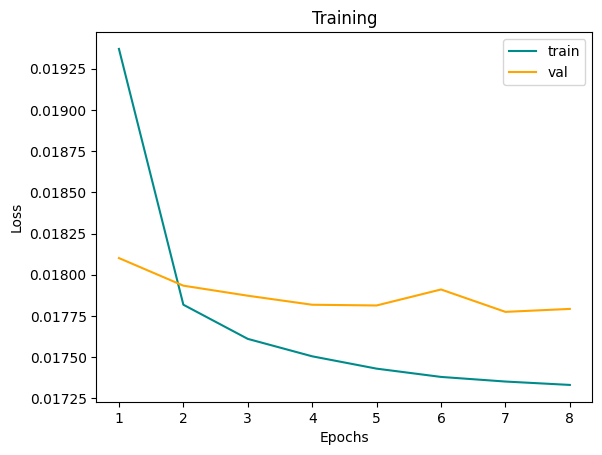

In [105]:
train_losses = training(cnn_classifier, train_loader, val_loader, 8)

In [143]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = cnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  57.61168599128723 %
Input sequence: 
 io non tanto averraggio tormiento de scrastareme da sto nigro cuorpo quanto de scantoniareme da ssa bella perzona cossì dicendo


In [113]:
with torch.no_grad():
    pred_labels = cnn_classifier(style0_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

dante_accuracy = 0
for lab in pred_labels:
    if lab.item() == 0:
        dante_accuracy +=1

dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.984267453294002


In [114]:
with torch.no_grad():
    pred_labels = cnn_classifier(style1_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

italian_accuracy = 0
for lab in pred_labels:
    if lab.item() == 1:
        italian_accuracy +=1

italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Italian: ', italian_accuracy)

Accuracy predicting Italian:  0.9872173058013766


In [115]:
with torch.no_grad():
    pred_labels = cnn_classifier(style2_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

neapolitan_accuracy = 0
for lab in pred_labels:
    if lab.item() == 2:
        neapolitan_accuracy +=1

neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Neapolitan: ', neapolitan_accuracy)

Accuracy predicting Neapolitan:  0.998


In [117]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall CNN Accuracy: ', overall_accuracy)

Overall CNN Accuracy:  0.9898282530317929


# RNN Classifier

In [144]:
rnn_classifier = RNNClassifier(embedding_matrix, hidden_dim, 1)

In [145]:
classifier_params = sum(p.numel() for p in rnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3107


 12%|█▎        | 1/8 [00:02<00:14,  2.12s/it]

====> Epoch: 1 Average train loss: 0.0280, Average val loss: 0.0261


 25%|██▌       | 2/8 [00:04<00:12,  2.04s/it]

====> Epoch: 2 Average train loss: 0.0208, Average val loss: 0.0191


 38%|███▊      | 3/8 [00:06<00:10,  2.09s/it]

====> Epoch: 3 Average train loss: 0.0160, Average val loss: 0.0151


 50%|█████     | 4/8 [00:07<00:07,  1.89s/it]

====> Epoch: 4 Average train loss: 0.0125, Average val loss: 0.0121


 62%|██████▎   | 5/8 [00:09<00:05,  1.83s/it]

====> Epoch: 5 Average train loss: 0.0097, Average val loss: 0.0096


 75%|███████▌  | 6/8 [00:11<00:03,  1.79s/it]

====> Epoch: 6 Average train loss: 0.0070, Average val loss: 0.0065


 88%|████████▊ | 7/8 [00:12<00:01,  1.72s/it]

====> Epoch: 7 Average train loss: 0.0047, Average val loss: 0.0050


100%|██████████| 8/8 [00:14<00:00,  1.80s/it]

====> Epoch: 8 Average train loss: 0.0043, Average val loss: 0.0055


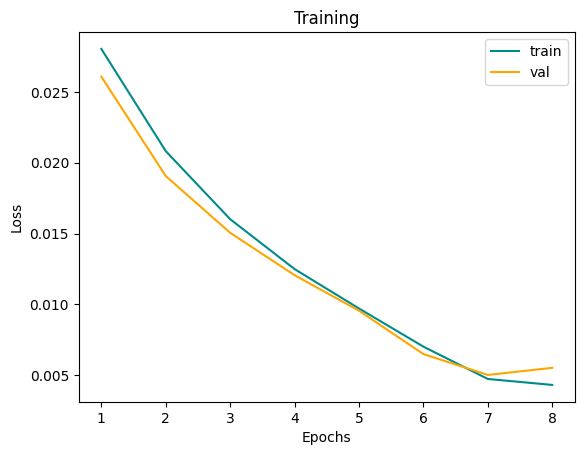

In [146]:
train_losses = training(rnn_classifier, train_loader, val_loader, 8)

In [153]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = rnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  96.19741439819336 %
Input sequence: 
 ve la dicere comme sta restava de mala voglia a sto pajese ma pocca lo cielo me l ha mannata


# RNN Classifier Accuracy

In [148]:
dante_accuracy = 0
with torch.no_grad():
    for data in style0_test:
        pred_label = rnn_classifier(data)
        if torch.argmax(pred_label).item() == 0:
            dante_accuracy += 1
    
dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9498525073746312


In [150]:
italian_accuracy = 0
with torch.no_grad():
    for data in style1_test:
        pred_label = rnn_classifier(data)
        if torch.argmax(pred_label).item() == 1:
            italian_accuracy += 1
    
italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Dante: ', italian_accuracy)

Accuracy predicting Dante:  0.9557522123893806


In [151]:
neapolitan_accuracy = 0
with torch.no_grad():
    for data in style2_test:
        pred_label = rnn_classifier(data)
        if torch.argmax(pred_label).item() == 2:
            neapolitan_accuracy += 1
    
neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Dante: ', neapolitan_accuracy)

Accuracy predicting Dante:  0.988


In [152]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall RNN Accuracy: ', overall_accuracy)

Overall RNN Accuracy:  0.9645349065880039


# GRU Classifier

In [61]:
gru_classifier = GRUClassifier(embedding_matrix, hidden_dim, 1)

In [62]:
classifier_params = sum(p.numel() for p in gru_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8067


 12%|█▎        | 1/8 [00:03<00:25,  3.58s/it]

====> Epoch: 1 Average train loss: 0.0230, Average val loss: 0.0157


 25%|██▌       | 2/8 [00:06<00:19,  3.26s/it]

====> Epoch: 2 Average train loss: 0.0094, Average val loss: 0.0068


 38%|███▊      | 3/8 [00:09<00:16,  3.22s/it]

====> Epoch: 3 Average train loss: 0.0045, Average val loss: 0.0039


 50%|█████     | 4/8 [00:12<00:12,  3.15s/it]

====> Epoch: 4 Average train loss: 0.0026, Average val loss: 0.0027


 62%|██████▎   | 5/8 [00:15<00:09,  3.09s/it]

====> Epoch: 5 Average train loss: 0.0017, Average val loss: 0.0021


 75%|███████▌  | 6/8 [00:18<00:06,  3.04s/it]

====> Epoch: 6 Average train loss: 0.0012, Average val loss: 0.0020


 88%|████████▊ | 7/8 [00:21<00:03,  3.02s/it]

====> Epoch: 7 Average train loss: 0.0009, Average val loss: 0.0019


100%|██████████| 8/8 [00:25<00:00,  3.13s/it]

====> Epoch: 8 Average train loss: 0.0007, Average val loss: 0.0017


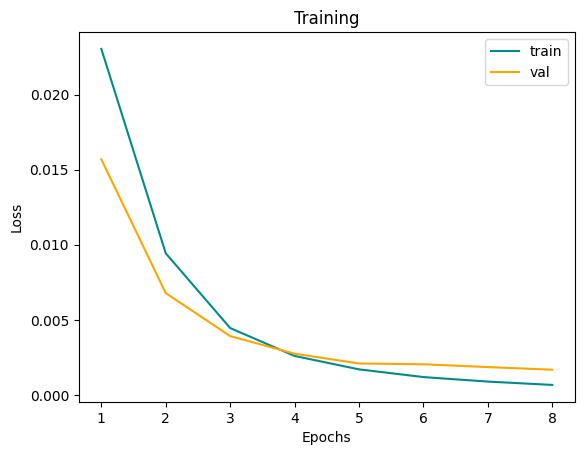

In [63]:
train_losses = training(gru_classifier, train_loader, val_loader, 8)

In [154]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = gru_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.8595654964447 %
Input sequence: 
 parente già era l caponsacco nel mercato disceso giù da fiesole e già era buon cittadino giuda e infangato io


# GRU Classifier Accuracy

In [155]:
dante_accuracy = 0
with torch.no_grad():
    for data in style0_test:
        pred_label = gru_classifier(data)
        if torch.argmax(pred_label, dim=-1).item() == 0:
            dante_accuracy += 1
    
dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9754178957718781


In [156]:
italian_accuracy = 0
with torch.no_grad():
    for data in style1_test:
        pred_label = gru_classifier(data)
        if torch.argmax(pred_label, dim = -1).item() == 1:
            italian_accuracy += 1
    
italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Dante: ', italian_accuracy)

Accuracy predicting Dante:  0.9901671583087512


In [157]:
neapolitan_accuracy = 0
with torch.no_grad():
    for data in style2_test:
        pred_label = gru_classifier(data)
        if torch.argmax(pred_label, dim = -1).item() == 2:
            neapolitan_accuracy += 1
    
neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Dante: ', neapolitan_accuracy)

Accuracy predicting Dante:  0.982


In [158]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall GRU Accuracy: ', overall_accuracy)

Overall GRU Accuracy:  0.9825283513602097


# LSTM Classifier

In [68]:
lstm_classifier = LSTMClassifier(embedding_matrix, hidden_dim, 1)

In [69]:
classifier_params = sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  10547


 12%|█▎        | 1/8 [00:01<00:11,  1.71s/it]

====> Epoch: 1 Average train loss: 0.0252, Average val loss: 0.0110


 25%|██▌       | 2/8 [00:03<00:09,  1.62s/it]

====> Epoch: 2 Average train loss: 0.0052, Average val loss: 0.0031


 38%|███▊      | 3/8 [00:04<00:07,  1.53s/it]

====> Epoch: 3 Average train loss: 0.0021, Average val loss: 0.0021


 50%|█████     | 4/8 [00:06<00:06,  1.51s/it]

====> Epoch: 4 Average train loss: 0.0013, Average val loss: 0.0017


 62%|██████▎   | 5/8 [00:07<00:04,  1.49s/it]

====> Epoch: 5 Average train loss: 0.0010, Average val loss: 0.0015


 75%|███████▌  | 6/8 [00:09<00:02,  1.47s/it]

====> Epoch: 6 Average train loss: 0.0007, Average val loss: 0.0019


 88%|████████▊ | 7/8 [00:10<00:01,  1.46s/it]

====> Epoch: 7 Average train loss: 0.0006, Average val loss: 0.0014


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]

====> Epoch: 8 Average train loss: 0.0005, Average val loss: 0.0012


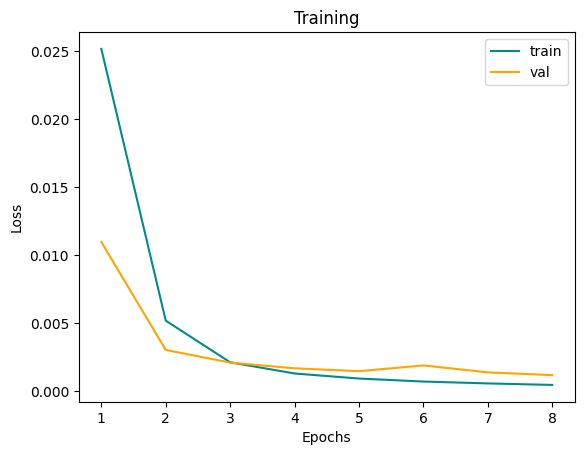

In [70]:
train_losses = training(lstm_classifier, train_loader, val_loader, 8)

In [159]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = lstm_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.85785484313965 %
Input sequence: 
 menti non capere in triangol due ottusi così vedi le cose contingenti anzi che sieno in sè mirando il punto


In [71]:
dante_accuracy = 0
with torch.no_grad():
    for data in style0_test:
        pred_label = lstm_classifier(data)
        if torch.argmax(pred_label).item() == 0:
            dante_accuracy += 1
    
dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9862340216322517


In [72]:
italian_accuracy = 0
with torch.no_grad():
    for data in style1_test:
        pred_label = lstm_classifier(data)
        if torch.argmax(pred_label).item() == 1:
            italian_accuracy += 1
    
italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Dante: ', italian_accuracy)

Accuracy predicting Dante:  0.9941002949852508


In [73]:
neapolitan_accuracy = 0
with torch.no_grad():
    for data in style2_test:
        pred_label = lstm_classifier(data)
        if torch.argmax(pred_label).item() == 2:
            neapolitan_accuracy += 1
    
neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Dante: ', neapolitan_accuracy)

Accuracy predicting Dante:  0.99


In [74]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall LSTM Accuracy: ', overall_accuracy)

Overall LSTM Accuracy:  0.9901114388725007


# Transformer Classifier

In [161]:
t_classifier = TClassifier(embedding_matrix, hidden_dim, 1)

In [162]:
classifier_params = sum(p.numel() for p in t_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3188599


 20%|██        | 1/5 [00:29<01:59, 29.91s/it]

====> Epoch: 1 Average train loss: 0.0012, Average val loss: 0.0006


 40%|████      | 2/5 [01:00<01:30, 30.08s/it]

====> Epoch: 2 Average train loss: 0.0003, Average val loss: 0.0007


 60%|██████    | 3/5 [01:30<01:00, 30.27s/it]

====> Epoch: 3 Average train loss: 0.0002, Average val loss: 0.0009


 80%|████████  | 4/5 [02:04<00:31, 31.52s/it]

====> Epoch: 4 Average train loss: 0.0001, Average val loss: 0.0012


100%|██████████| 5/5 [02:36<00:00, 31.21s/it]

====> Epoch: 5 Average train loss: 0.0001, Average val loss: 0.0012


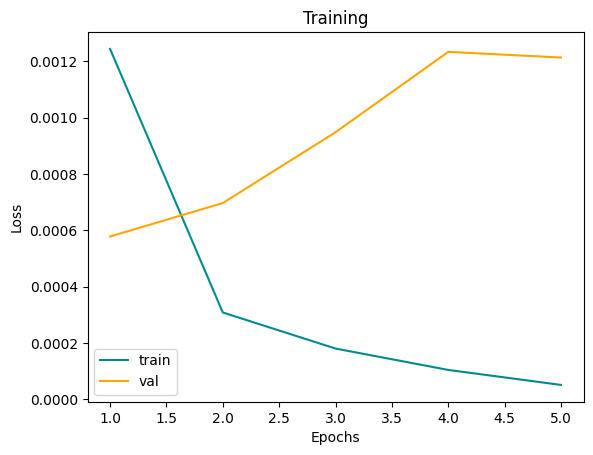

In [163]:
train_losses = training(t_classifier, train_loader, val_loader, 5)

In [164]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = t_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.9979019165039 %
Input sequence: 
 t eran possenti il nome del bel fior ch io sempre invoco e mane e sera tutto mi ristrinse l


# Transformer Classifier Accuracy

In [165]:
with torch.no_grad():
    pred_labels = t_classifier(style0_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

dante_accuracy = 0
for lab in pred_labels:
    if lab.item() == 0:
        dante_accuracy +=1

dante_accuracy = dante_accuracy/len(style0_test)
print('Accuracy predicting Dante: ', dante_accuracy)

Accuracy predicting Dante:  0.9734513274336283


In [166]:
with torch.no_grad():
    pred_labels = t_classifier(style1_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

italian_accuracy = 0
for lab in pred_labels:
    if lab.item() == 1:
        italian_accuracy +=1

italian_accuracy = italian_accuracy/len(style1_test)
print('Accuracy predicting Italian: ', italian_accuracy)

Accuracy predicting Italian:  0.9990167158308751


In [167]:
with torch.no_grad():
    pred_labels = t_classifier(style2_test)

pred_labels = torch.argmax(pred_labels,dim=-1).squeeze(0)

neapolitan_accuracy = 0
for lab in pred_labels:
    if lab.item() == 2:
        neapolitan_accuracy +=1

neapolitan_accuracy = neapolitan_accuracy/len(style2_test)
print('Accuracy predicting Neapolitan: ', neapolitan_accuracy)

Accuracy predicting Neapolitan:  1.0


In [168]:
overall_accuracy = (dante_accuracy + italian_accuracy + neapolitan_accuracy)/3
print('Overall Transformer Accuracy: ', overall_accuracy)

Overall Transformer Accuracy:  0.9908226810881677
